In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import entropy2
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,8)

In [3]:
def ground_truth(x,y):
    return (1.3*x-.5)*(1.3*x-.5) + (y-.5)*(y-.5) < .05

In [4]:
def createSamples(N, xl, xr, yu, yo, ground_truth):
    """
        ground_truth is a function that calculates the "true" label, given coordinates x and y
        Produce N samples in the rectangle [xl, xr, yu, yo] with the given ground_truth
    """
    np.random.seed(1234)
    x = np.random.uniform(xl,xr,N)
    y = np.random.uniform(yu,yo,N)
    c = ground_truth(x, y) * 1.0
    return x, y, c

In [5]:
N = 2000

In [6]:
sx, sy, labels = createSamples(N, 0, 1, 0, 1, ground_truth)
points=np.array([sx, sy])

### The statistical experiment
Please interpret the experiment in the following way: There is some mysterious source of points. Let's call it RED. And there's another source, also producing points - and we call it BLUE. RED distributes its points in a region, defined by some ground truth. BLUE avoids exactly that region. Now, given some points with known origin, we attempt to train a neural network to tell the source from the position of a particular point.   

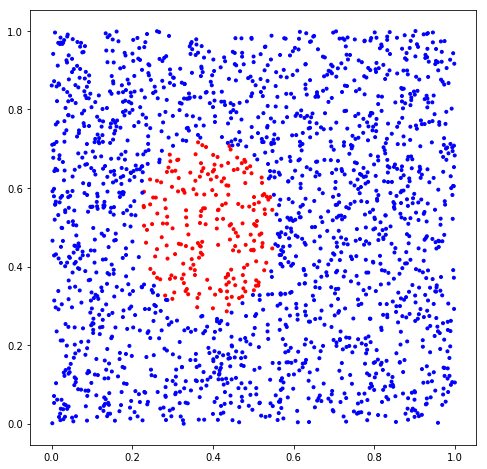

In [7]:
plt.scatter(sx, sy, c=labels, cmap="bwr", marker='.')
plt.savefig("images/rb-distribution.png")

### Using Tensorflow tf.data.Datasets

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
training_data = (tf.transpose(points), tf.transpose(labels))
ds_training = tf.data.Dataset.from_tensor_slices(training_data)
it_tr = ds_training.batch(N).repeat().make_one_shot_iterator().get_next()

samples_it= it_tr[0]
labels_it = it_tr[1]

In [10]:
# Hyperparameters governing the differentiable entropy computation
n_bins=5
alpha = 1e3

We're going to use a sigmoid network, thus all ranges span from 0 to 1:

In [11]:
min_max2 = [np.array([0, 0]), np.array([1,1])]
min_max3 = [np.array([0, 0, 0]), np.array([1, 1, 1])]

### Entropy and mutual information in the input signal (the point coordinates)
Compare: With no knowledge of the color, we see a uniform distribution with 5x5=25 buckets - this is what we expect the computed entropy to be close to:

In [12]:
init = tf.global_variables_initializer()

In [13]:
theoretical_limit = -math.log(1/n_bins/n_bins)
actual_entropy, bin_counts = sess.run(entropy2.entropy(samples_it, n_bins, alpha, *min_max2))
_, info_gain = sess.run([init, entropy2.info_gain(samples_it, labels, 2, n_bins, alpha, *min_max2)])
print("theoretical limit: %s - actual entropy: %s" %(theoretical_limit, actual_entropy))
print("information gain: %s" % info_gain)

theoretical limit: 3.2188758248682006 - actual entropy: 3.2127104744772375
information gain: 0.21209776767006439


### Defining the network
We define a little network with two hidden layers of 3 neurons each

In [14]:
W1 = np.array([[1.6, .4], [.6, -1.2], [-.6, 1.6]])     # 3x2 weight Matrix towards the first hidden layer
b1 = np.array([[-1, 1, .3]]).T                           # bias of the first hidden layer
W2 = np.array([[1, .2, -.3], [.5, .2, -.3], [.2, 1, -.2]])  # 3x3 weight Matrix towards the second hidden layer
b2 = np.array([[.2, .1, -.4]]).T                        # bias of the 2nd hidden layer
W3 = np.array([[.2, .1, -.01], [.2, 1, .2]])            # 2x3 weight Matrix towards the output layer
b3 = np.array([[-.2, .1]]).T                             # bias of the output layer

W1_i=tf.constant_initializer(W1.T)
b1_i=tf.constant_initializer(b1)
W2_i=tf.constant_initializer(W2.T)
b2_i=tf.constant_initializer(b2)
W3_i=tf.constant_initializer(W3.T)
b3_i=tf.constant_initializer(b3)

_dense1=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W1_i, bias_initializer=b1_i)
_dense2=tf.layers.Dense(3, activation=tf.nn.sigmoid, kernel_initializer=W2_i, bias_initializer=b2_i)
_logits=tf.layers.Dense(2, kernel_initializer=W3_i, bias_initializer=b3_i)    

def get_layers(x):
    hidden1 = _dense1(x)
    hidden2 = _dense2(hidden1)
    y = _logits(hidden2)
    return hidden1, hidden2, y

In [15]:
h1, h2, logits = get_layers(samples_it)
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
_h1, _h2, _lg, sc = sess.run([h1, h2, logits, labels_it])
ph1 = [_h1[:,i] for i in range(3)]
ph2 = [_h2[:,i] for i in range(3)]
plg = [_lg[:,i] for i in range(2)]

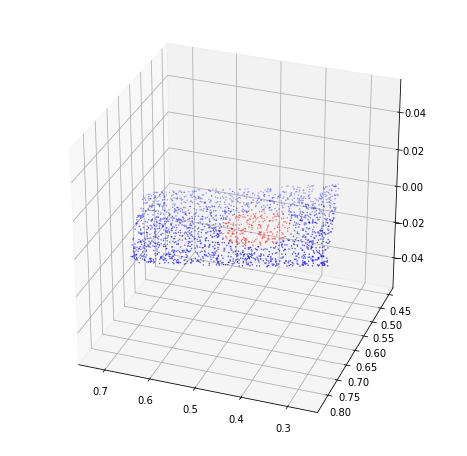

In [17]:
matplotlib.rcParams['figure.figsize'] = (8,8)
plt.axes(projection='3d', elev=30, azim=110)
plt.scatter(*ph1, c=sc, cmap="bwr", marker='.')

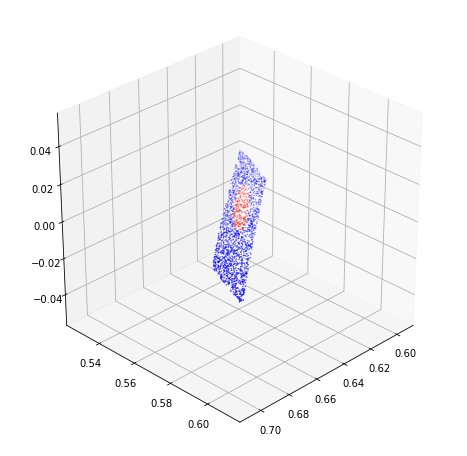

In [18]:
plt.axes(projection='3d', elev=30, azim=45)
plt.scatter(*ph2, c=sc, cmap="bwr", marker='.')

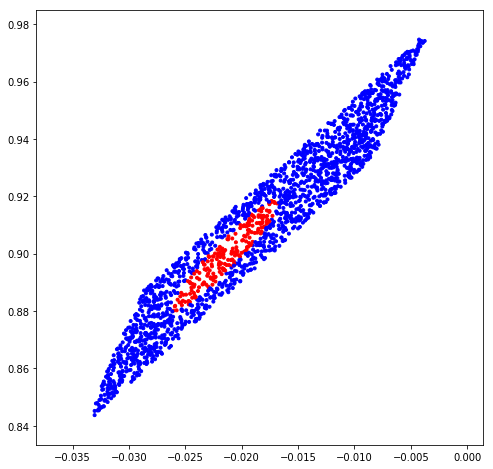

In [19]:
plt.scatter(*plg, c=sc, cmap="bwr", marker='.')

In [20]:
oh_labels=tf.one_hot(labels, depth=2)
objective_ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=oh_labels))
optimizer2 = tf.train.AdamOptimizer(learning_rate=1e-2)
train_ce = optimizer2.minimize(objective_ce)

In [21]:
info_gain_hidden1 = -entropy2.info_gain(h1, labels, 2, n_bins, alpha, *min_max3)
info_gain_hidden2 = -entropy2.info_gain(h2, labels, 2, n_bins, alpha, *min_max3)
preds = tf.argmax(logits,axis=1)

In [22]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, labels), dtype=tf.float64))

In [23]:
init = tf.global_variables_initializer()
sess.run(init)
info_gain1 = []
info_gain2 = []
cross_ent = []
acc_cum  = []

In [24]:
def single_batch(n_batch):
    for _ in range(n_batch):
        _, _ce, _ig1, _ig2, _ac = sess.run([train_ce, objective_ce, info_gain_hidden1, info_gain_hidden2, accuracy])

    cross_ent.append(_ce)
    info_gain1.append(_ig1)
    info_gain2.append(_ig2)
    acc_cum.append(_ac)
    print("Loss: %s, Accuracy: %s" % (_ce, _ac))

In [25]:
single_batch(50)

Loss: 0.36430828040292956, Accuracy: 0.8925


In [26]:
for i in range(40):
    single_batch(50)
print("Done.")

Loss: 0.3405873804390176, Accuracy: 0.8925
Loss: 0.340497586328071, Accuracy: 0.8925
Loss: 0.34037647270359217, Accuracy: 0.8925
Loss: 0.34021604406297395, Accuracy: 0.8925
Loss: 0.3399997973893197, Accuracy: 0.8925
Loss: 0.3396990763438598, Accuracy: 0.8925
Loss: 0.3392624804055031, Accuracy: 0.8925
Loss: 0.33859642620855435, Accuracy: 0.8925
Loss: 0.3375292296143821, Accuracy: 0.8925
Loss: 0.3357558093428887, Accuracy: 0.8925
Loss: 0.3328054252796899, Accuracy: 0.8925
Loss: 0.3282029292623433, Accuracy: 0.8925
Loss: 0.32196769505968836, Accuracy: 0.8925
Loss: 0.3148874110916631, Accuracy: 0.8925
Loss: 0.30785168601054097, Accuracy: 0.8925
Loss: 0.30113288141523537, Accuracy: 0.8925
Loss: 0.2945452056793438, Accuracy: 0.8925
Loss: 0.28785239254329553, Accuracy: 0.8925
Loss: 0.2808814992137808, Accuracy: 0.8925
Loss: 0.2736017305254102, Accuracy: 0.8925
Loss: 0.26625505730290916, Accuracy: 0.8925
Loss: 0.2592468677222032, Accuracy: 0.8925
Loss: 0.25289343342922294, Accuracy: 0.8925
Los

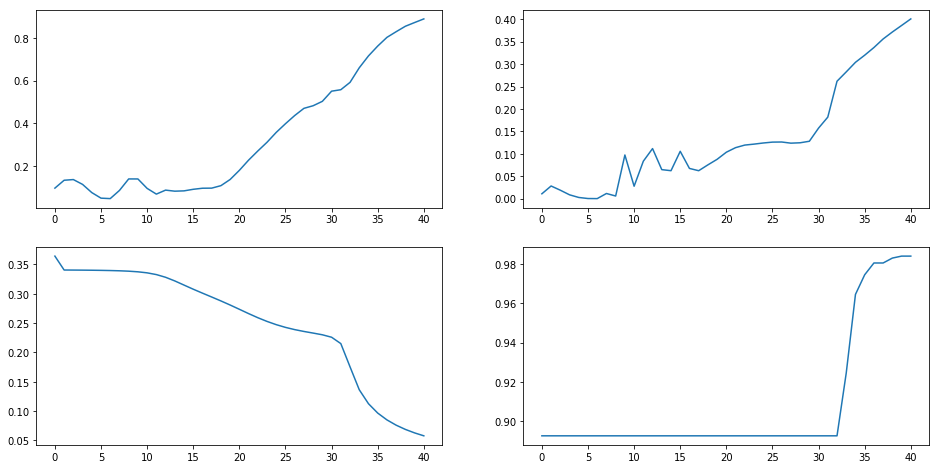

In [27]:
matplotlib.rcParams['figure.figsize'] = (16,8)
plt.subplot(2,2,1)
plt.plot(-np.array(info_gain1))
plt.subplot(2,2,2)
plt.plot(-np.array(info_gain2))
plt.subplot(2,2,3)
plt.plot(np.array(cross_ent))
plt.subplot(2,2,4)
plt.plot(np.array(acc_cum))